# COSC 4337 - Homework 3: RNNs for Time Series Forecasting (Netflix Stocks) 📈

**Objective:** The goal of this assignment is to build, train, and evaluate Recurrent Neural Networks (RNNs), including GRU and LSTM variants, for predicting Netflix stock prices.

***Note on Frameworks***

This notebook uses `Keras` with a `TensorFlow` backend. If you are more comfortable with `PyTorch`, you are welcome to complete the assignment using it. The core concepts are directly transferable. Feel free to change code as you see fit as long as it follows the tasks.

## Problem Statement

You are tasked with predicting the **closing price** of Netflix (NFLX) stock for the next day based on historical daily data.

**Dataset:**
We will use a dataset containing historical daily stock prices for Netflix (NFLX), including Open, High, Low, Close, Adj Close, and Volume. The specific file used (`NFLX.csv`) covers 2018-2022.

**Dataset Features (Input):**
1.  A sequence of a *look_back* number of past closing prices (or other features in later exercises).

**Dataset Target (Output):**
* The closing price for the *next* trading day.

Link to original dataset source concept: https://www.kaggle.com/datasets/jainilcoder/netflix-stock-price-prediction




## Setup: Import Libraries and Set Seed


In [1]:
# === Import Libraries ===
import numpy as np
import pandas as pd
from tensorflow import random
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# === Set Seed ===
seed = 4337
np.random.seed(seed)
random.set_seed(seed)

## Data Loading and Initial Exploration


In [2]:
# === 1. Load Data ===

data_path = "NFLX.csv"

# YOUR CODE HERE: Load the dataset from the url into a pandas DataFrame named 'df'.
# Make sure to parse the 'Date' column as datetime objects using the 'parse_dates' argument.
import pandas as pd
df = pd.read_csv(data_path, parse_dates=["Date"])

# Display the first few rows
print("First 5 rows of the dataset:")
# ... YOUR CODE ...
print(df.head(), "\n")

# Display basic info about the DataFrame
print("\nDataFrame Info:")
# ... YOUR CODE ...
print(df.info(), "\n")

First 5 rows of the dataset:
        Date        Open        High         Low       Close   Adj Close  \
0 2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1 2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2 2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3 2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4 2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   

     Volume  
0  11896100  
1  12595800  
2   8981500  
3   9306700  
4  16906900   


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1009 non-null   datetime64[ns]
 1   Open       1009 non-null   float64       
 2   High       1009 non-null   float64       
 3   Low        1009 non-null   float64       
 4   Close      1009 no

## Select Target Variable and Visualize

We are selecting the 'Close' price as our target variable and plotting it over time.
We need to isolate the variable we want to predict. Plotting helps visualize the trends, seasonality, and potential challenges in the data.

Shape of close_prices: (1009, 1)


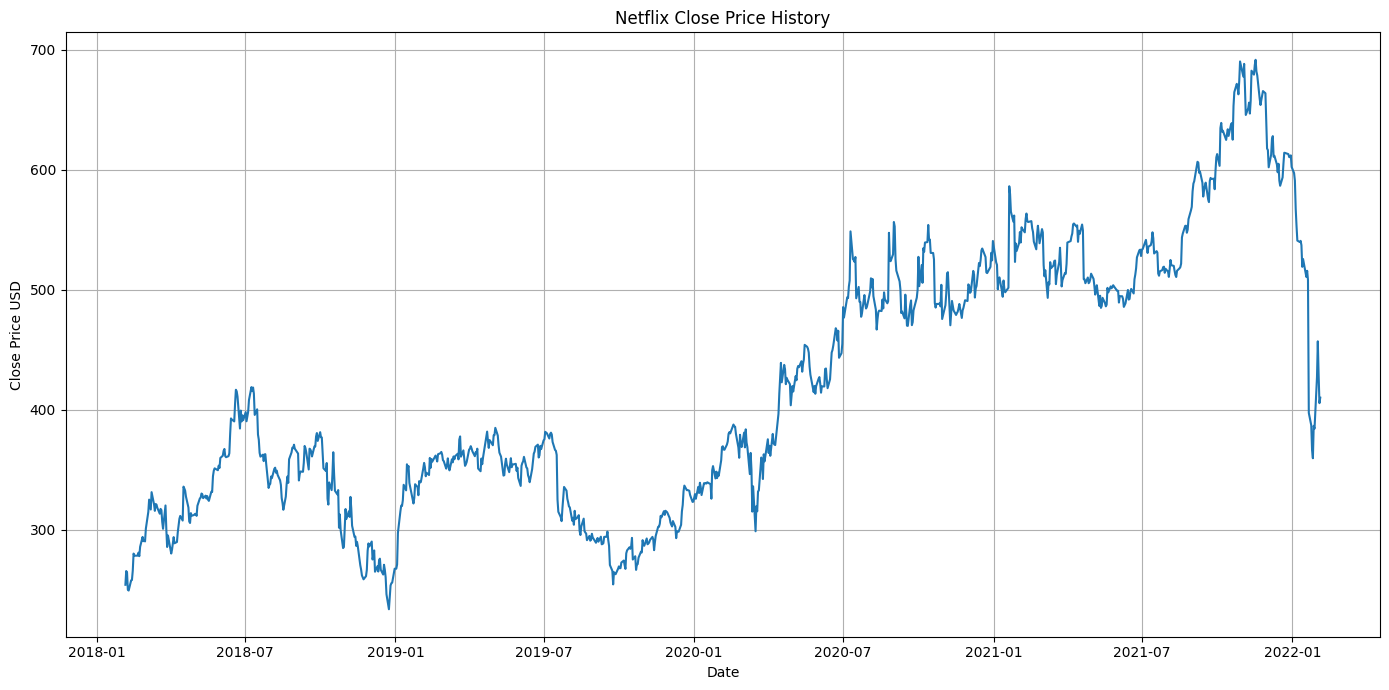

In [3]:
# === 2a. Select Target Variable ===
# YOUR CODE HERE: Extract the 'Close' column as a numpy array, ensure it's float32, and reshape it to be a 2D array (samples, 1 feature).
# Store this in a variable called 'close_prices'.
close_prices = df["Close"].astype(np.float32).to_numpy().reshape(-1, 1)

print(f"Shape of close_prices: {close_prices.shape}")

# === 2b. Visualize the Close Price ===
plt.figure(figsize=(14, 7))
# YOUR CODE HERE: Plot the 'Date' column from the DataFrame 'df' on the x-axis
# and the 'close_prices' array on the y-axis.
# Add a title 'Netflix Close Price History', xlabel 'Date', and ylabel 'Close Price USD'.

plt.plot(df["Date"], close_prices)
plt.title("Netflix Close Price History")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.grid(True)
plt.tight_layout()
plt.show()

## Scale the Data

Neural networks generally perform better with normalized input data. Scaling prevents features with large values from disproportionately influencing the model's learning process and helps gradients flow more effectively.

In [4]:
# === 3. Scale the Data ===
from sklearn.preprocessing import MinMaxScaler

# YOUR CODE HERE: Initialize a MinMaxScaler with feature_range=(0, 1).
scaler = MinMaxScaler(feature_range=(0, 1))

# YOUR CODE HERE: Apply the scaler to 'close_prices' using fit_transform and store the result in 'dataset_scaled'.
dataset_scaled = scaler.fit_transform(close_prices)

print("Shape of scaled dataset:", dataset_scaled.shape)
print("First 5 scaled values:\n", dataset_scaled[:5])

Shape of scaled dataset: (1009, 1)
First 5 scaled values:
 [[0.04451627]
 [0.06954849]
 [0.06701463]
 [0.03542954]
 [0.03405339]]


## Define Sequence Creation Function

We are creating a reusable function to transform the time series data into input sequences (X) and target outputs (y).
Define a function `create_sequences` that takes the scaled data and `look_back` period as input. It iterates through the data, creating sequences of length `look_back` and pairing them with the immediately following data point as the target. RNNs require input data structured as sequences. This function automates the process of generating these sequence-target pairs, which is fundamental for training.

In [5]:
# === 4. Define Sequence Creation Function ===
def create_sequences(data, look_back=1):
    """Converts univariate time series into (X, y) sequences for RNNs."""
    X, y = [], []
    for i in range(len(data) - look_back):
        seq = data[i:i + look_back, 0]
        target = data[i + look_back, 0]
        X.append(seq)
        y.append(target)
    X = np.array(X)
    y = np.array(y)
    # reshape X to (samples, timesteps, features=1)
    return X.reshape((X.shape[0], X.shape[1], 1)), y

# Test the function (optional)
test_data = np.arange(10).reshape(-1, 1).astype(np.float32)
testX, testY = create_sequences(test_data, 3)
print("Test X shape:", testX.shape)
print("Test Y shape:", testY.shape)
print("Test X (look_back=3):\n", testX.squeeze()[:3])
print("Test Y (look_back=3):\n", testY[:3])

Test X shape: (7, 3, 1)
Test Y shape: (7,)
Test X (look_back=3):
 [[0. 1. 2.]
 [1. 2. 3.]
 [2. 3. 4.]]
Test Y (look_back=3):
 [3. 4. 5.]


## Create Sequences and Reshape

We are applying the `create_sequences` function and reshaping the resulting input data `X`.
Call the function with the scaled data and the desired `look_back`. Then use `np.reshape` on `X`.
We are doing this to generate the actual training/testing sequences based on our chosen lookback period (e.g., 60 days). The reshaping step is mandatory to get the 3D format `[samples, timesteps, features]` required by Keras RNN layers.

In [6]:
# === 5a. Create Sequences ===
# We'll use the past 60 days (timesteps) to predict the next day.
look_back = 60

# YOUR CODE HERE: Call the 'create_sequences' function with 'dataset_scaled' and 'look_back'.
# Store the results in variables 'X' and 'y'.
X, y = create_sequences(dataset_scaled, look_back)

print(f"Created {X.shape[0]} sequences.")
print("Shape of X before reshape:", X.shape)
print("Shape of y:", y.shape)

# === 5b. Reshape Input Data for RNN ===
# Reshape X to the required 3D format: [samples, time steps, features]
# YOUR CODE HERE: Reshape 'X' using np.reshape. The new shape should have:
# - X.shape[0] as the number of samples
# - X.shape[1] (which is look_back) as the number of timesteps
# - 1 as the number of features (since we are only using 'Close' price)
if X.ndim == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))

print("Shape of X after reshape:", X.shape)

Created 949 sequences.
Shape of X before reshape: (949, 60, 1)
Shape of y: (949,)
Shape of X after reshape: (949, 60, 1)


## Split Data into Training and Testing Sets

We are dividing the sequential data into a set for training the model and a separate set for evaluating its performance.
Calculate a split point (e.g., 80% mark) and slicing the `X` and `y` arrays. 
For time series forecasting, the model must learn from the past to predict the future. We train on the earlier portion of the data and test on the later portion to mimic this real-world scenario.

**Crucial to notice that we do not shuffle the data.**

In [8]:
# === 6. Train/Test Split (Sequential) ===
# Use 80% of the data for training, 20% for testing.
train_size_percentage = 0.80

# YOUR CODE HERE: Calculate the integer index 'train_size' representing the end of the training data.
train_size = int(len(X) * train_size_percentage)

# YOUR CODE HERE: Slice the 'X' and 'y' arrays to create:
# - X_train, y_train (from the beginning up to train_size)
# - X_test, y_test (from train_size to the end)
X_train, y_train = X[:train_size], y[:train_size]
X_test,  y_test  = X[train_size:], y[train_size:]

# --- Verification --- 
print("=== Split Shapes ===")
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

=== Split Shapes ===
Shape of X_train: (759, 60, 1)
Shape of y_train: (759,)
Shape of X_test:  (190, 60, 1)
Shape of y_test:  (190,)


## Exercise 1: Build and Compare RNN Models

For this task define, compile, and train three different types of recurrent neural networks: SimpleRNN, GRU, and LSTM.

We will compare the performance of these architectures. Stock prices have **long-term dependencies** (e.g., the price 60 days ago can still influence today's trend). 
* **SimpleRNNs** struggle with this due to the **vanishing gradient problem**.
* **LSTMs (Long Short-Term Memory)** use gates (forget, input, output) and a cell state to selectively remember or forget information over long sequences, mitigating the vanishing gradient issue.
* **GRUs (Gated Recurrent Units)** are a simplified version of LSTMs with fewer gates (update, reset), often achieving similar performance with less computation.

### 1a. Define Model Architectures
Specify the layers for each model.
Use `Sequential()` and add the appropriate RNN layer (`SimpleRNN`, `GRU`, `LSTM`) with 32 units, followed by a `Dense` output layer with 1 unit.
This sets up the structure of each network. 32 units is an arbitrary starting point for hidden layer complexity. The `Dense(1)` layer is required for our regression task (predicting one continuous value).

In [9]:
# === Define Input Shape ===
input_shape = (look_back, 1)

# ---- Define Model 1 (SimpleRNN) ----
model_rnn = Sequential(name="SimpleRNN_Model")
# Add SimpleRNN layer with 32 units
model_rnn.add(SimpleRNN(32, input_shape=input_shape))
# Output layer (regression -> 1 value)
model_rnn.add(Dense(1))

# ---- Define Model 2 (GRU) ----
model_gru = Sequential(name="GRU_Model")
# Add GRU layer with 32 units
model_gru.add(GRU(32, input_shape=input_shape))
# Output layer
model_gru.add(Dense(1))

# ---- Define Model 3 (LSTM) ----
model_lstm = Sequential(name="LSTM_Model")
# Add LSTM layer with 32 units
model_lstm.add(LSTM(32, input_shape=input_shape))
# Output layer
model_lstm.add(Dense(1))

print("Models defined.")

Models defined.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 1b. Compile Models


In [10]:
# === Compile all models ===
print("Compiling models...")

model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Print one model summary as an example
print("\n=== Model 3 (LSTM) Summary ===")
model_lstm.summary()

Compiling models...

=== Model 3 (LSTM) Summary ===


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

### 1c. Train the Models


 We use `validation_split=0.1` to monitor performance on unseen data during training.

In [11]:
epochs = 50
batch_size = 32

print(f"Training Model 1 (SimpleRNN) for {epochs} epochs...")
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1
)

Training Model 1 (SimpleRNN) for 50 epochs...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8109e-04 - val_loss: 0.0014
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1858e-04 - val_loss: 0.0014
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7049e-04 - val_loss: 0.0013
Epoch 12/50
22/2

In [12]:
print(f"\nTraining Model 2 (GRU) for {epochs} epochs...")
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1
)



Training Model 2 (GRU) for 50 epochs...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0771 - val_loss: 0.0104
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120 - val_loss: 0.0316
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - val_loss: 0.0077
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.9773e-04 - val_loss: 0.0016
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.8053e-04 - val_loss: 0.0016
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6056e-04 - val_loss: 0.0016
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4121e-04 - val_loss: 0.0016
Epoch 12/50
22/2

In [13]:
print(f"\nTraining Model 3 (LSTM) for {epochs} epochs...")
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1
)

print("\nAll models trained successfully! ✅")


Training Model 3 (LSTM) for 50 epochs...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1113 - val_loss: 0.0039
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - val_loss: 0.0253
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 12/50
22/22 ━━━━━━━━━━

### 1d. Evaluate Models on Test Data


In [14]:
# === Evaluate Models on Test Set ===
print("\nEvaluating models on the test set...")

mse_rnn  = model_rnn.evaluate(X_test, y_test, verbose=0)
print(f"Model 1 (SimpleRNN) – Test MSE: {mse_rnn:.6f}")

mse_gru  = model_gru.evaluate(X_test, y_test, verbose=0)
print(f"Model 2 (GRU)        – Test MSE: {mse_gru:.6f}")

mse_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Model 3 (LSTM)       – Test MSE: {mse_lstm:.6f}")

# RMSE (still in scaled units because targets were scaled)
rmse_rnn  = np.sqrt(mse_rnn)
rmse_gru  = np.sqrt(mse_gru)
rmse_lstm = np.sqrt(mse_lstm)

print(f"\nModel 1 (SimpleRNN) – Test RMSE: {rmse_rnn:.6f} (scaled units)")
print(f"Model 2 (GRU)       – Test RMSE: {rmse_gru:.6f} (scaled units)")
print(f"Model 3 (LSTM)      – Test RMSE: {rmse_lstm:.6f} (scaled units)")


Evaluating models on the test set...
Model 1 (SimpleRNN) – Test MSE: 0.001068
Model 2 (GRU)        – Test MSE: 0.001057
Model 3 (LSTM)       – Test MSE: 0.001870

Model 1 (SimpleRNN) – Test RMSE: 0.032676 (scaled units)
Model 2 (GRU)       – Test RMSE: 0.032510 (scaled units)
Model 3 (LSTM)      – Test RMSE: 0.043242 (scaled units)


## Exercise 2: More Evaluation & Tuning Experiments



### 2a. Plotting Learning Curves
We will visualize how training and validation loss changed during training for each model.
Define a function to plot `loss` and `val_loss` from a model's history object. Call this function for each of the three trained models.
This helps diagnose **overfitting**.


Plotting Learning Curves for Each Model...


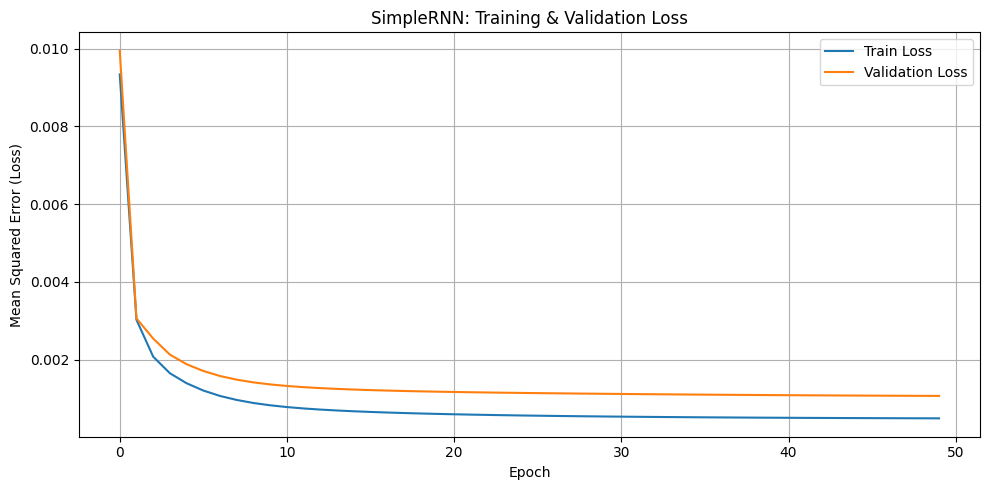

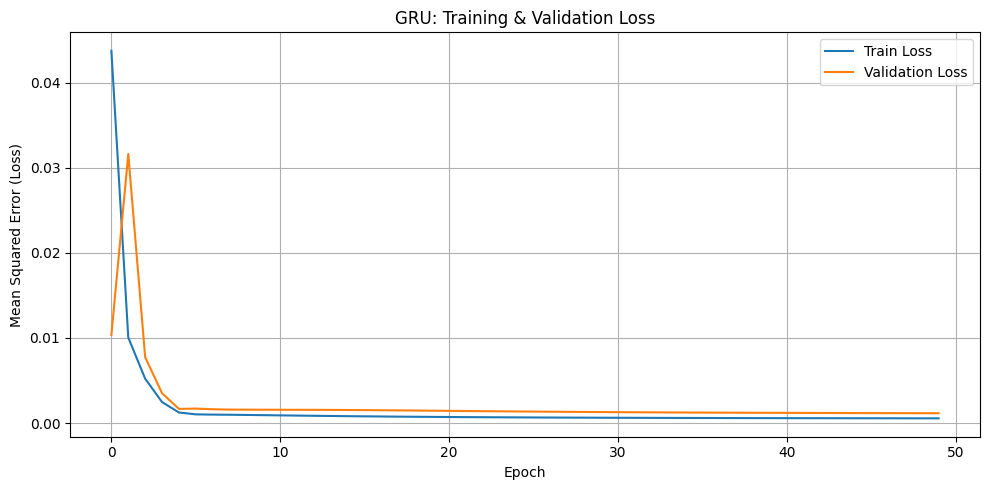

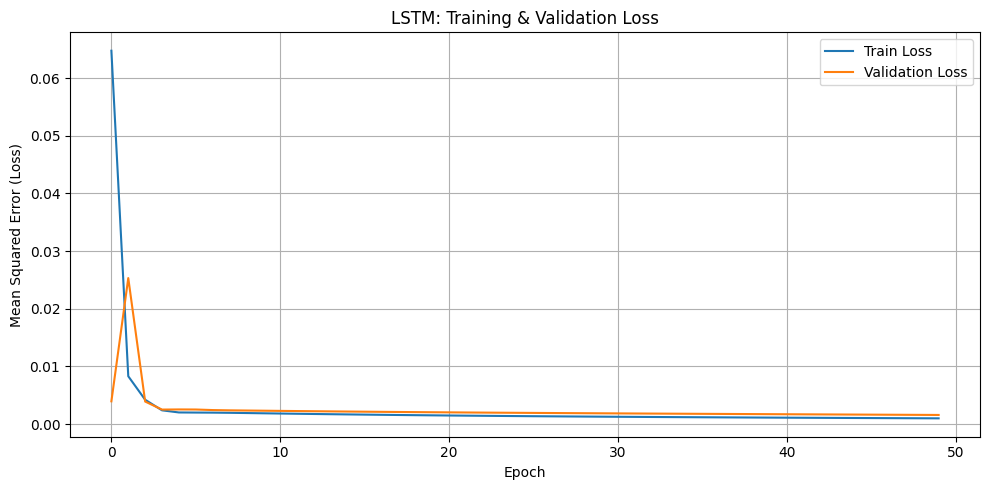

In [15]:
def plot_loss_curves(history, model_name):
    plt.figure(figsize=(10, 5))
    # training loss
    plt.plot(history.history["loss"], label="Train Loss")
    # validation loss (if available)
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{model_name}: Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (Loss)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\nPlotting Learning Curves for Each Model...")
plot_loss_curves(history_rnn,  "SimpleRNN")
plot_loss_curves(history_gru,  "GRU")
plot_loss_curves(history_lstm, "LSTM")

### 2b. Plotting Predictions vs. Actual
We will compare the models predictions on the test set against the actual stock prices visually. We can see if the models capture the overall trend, magnitude, and turning points of the actual stock price.


Generating predictions for final plot...


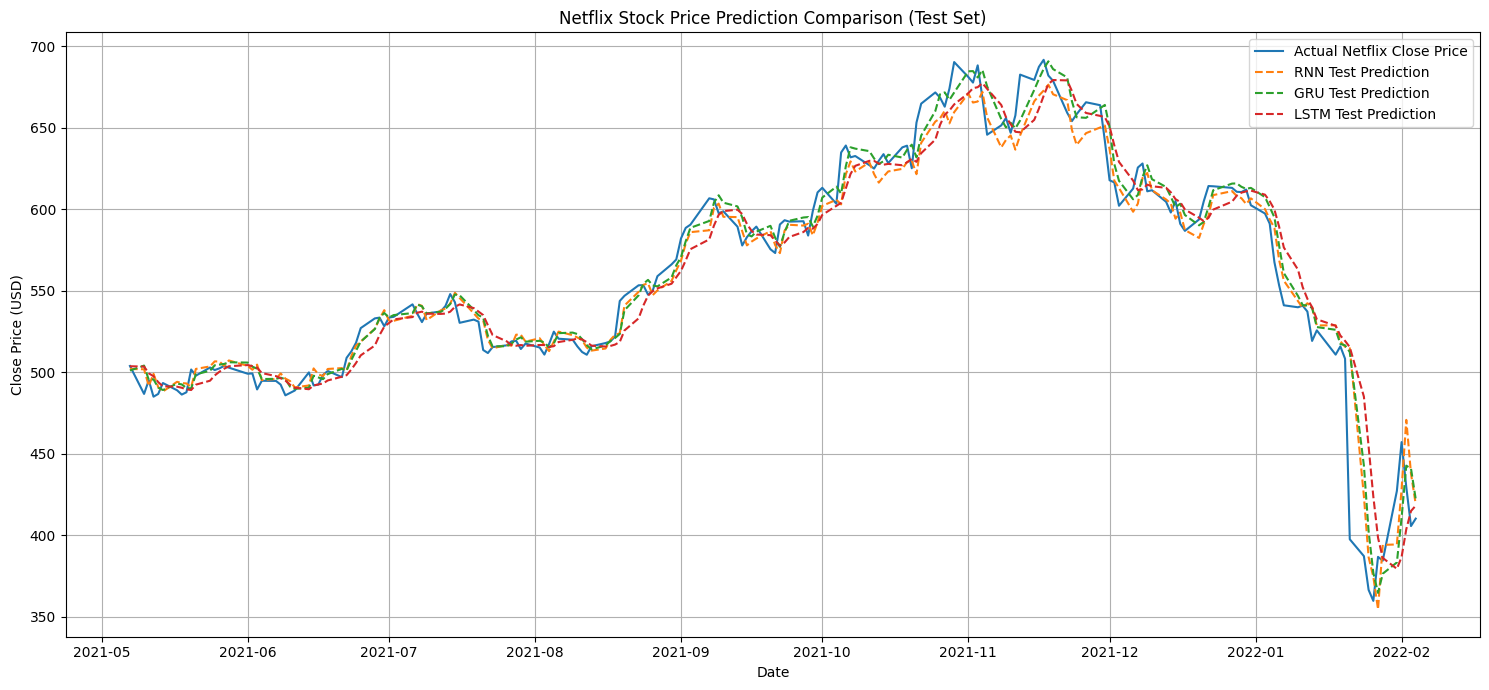

In [16]:
print("\nGenerating predictions for final plot...")

# === Make Predictions ===
test_predict_rnn  = model_rnn.predict(X_test,  verbose=0)
test_predict_gru  = model_gru.predict(X_test,  verbose=0)
test_predict_lstm = model_lstm.predict(X_test, verbose=0)

# === Inverse Transform Predictions (back to USD) ===
test_predict_rnn  = scaler.inverse_transform(test_predict_rnn)
test_predict_gru  = scaler.inverse_transform(test_predict_gru)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)

# === Inverse Transform Actual Test Data ===
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Dates corresponding to the test targets
test_dates = df["Date"].iloc[look_back + train_size : look_back + len(X)]

# === Plotting ===
plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test_actual, label="Actual Netflix Close Price")
plt.plot(test_dates, test_predict_rnn,  linestyle="--", label="RNN Test Prediction")
plt.plot(test_dates, test_predict_gru,  linestyle="--", label="GRU Test Prediction")
plt.plot(test_dates, test_predict_lstm, linestyle="--", label="LSTM Test Prediction")
plt.title("Netflix Stock Price Prediction Comparison (Test Set)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2c. Experiment: Stacked LSTM
We will build a deeper LSTM network with two layers. By Adding a second `LSTM(32)` layer. The *first* LSTM layer needs `return_sequences=True`.
Stacking allows the network to potentially learn more complex, hierarchical temporal patterns.


--- Experiment: Stacked LSTM ---


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Stacked_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)


Training Stacked LSTM for 50 epochs...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0596 - val_loss: 0.0208
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 12/50
22/22 ━━━━━

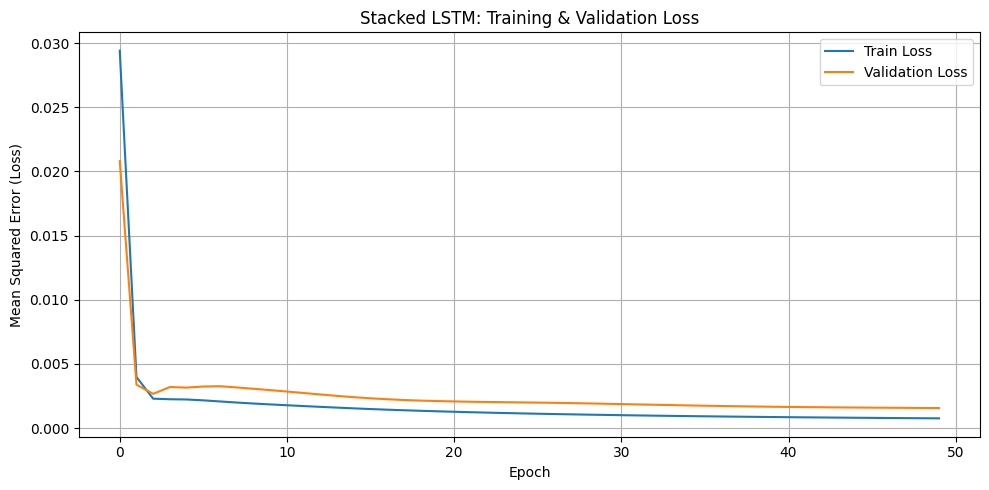

In [17]:
print("\n--- Experiment: Stacked LSTM ---")
model_stacked_lstm = Sequential(name="Stacked_LSTM_Model")

# 1) First LSTM must return sequences so the next LSTM receives a sequence
model_stacked_lstm.add(LSTM(32, return_sequences=True, input_shape=input_shape))
# 2) Second LSTM consumes the sequence and returns a vector
model_stacked_lstm.add(LSTM(32))
# 3) Regression head
model_stacked_lstm.add(Dense(1))

# Compile
model_stacked_lstm.compile(optimizer="adam", loss="mean_squared_error")
model_stacked_lstm.summary()

# Train
print(f"\nTraining Stacked LSTM for {epochs} epochs...")
history_stacked = model_stacked_lstm.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1
)

# Evaluate
mse_stacked = model_stacked_lstm.evaluate(X_test, y_test, verbose=0)
print(f"\nStacked LSTM – Test MSE: {mse_stacked:.6f}")

# Plot learning curves
plot_loss_curves(history_stacked, "Stacked LSTM")

### 2d. Experiment: LSTM with Dropout
We are adding Dropout regularization to the simple LSTM model by Inserting a `Dropout(0.2)` layer *after* the LSTM layer and *before* the final Dense layer.
Dropout randomly deactivates a fraction of neurons during training, forcing the network to learn more robust representations and reducing the risk of overfitting.


--- Experiment: LSTM with Dropout ---


Model: "Dropout_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM with Dropout for 50 epochs...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0915 - val_loss: 0.0031
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - val_loss: 0.0184
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 12/50
22/22 ━━━━━━━━━

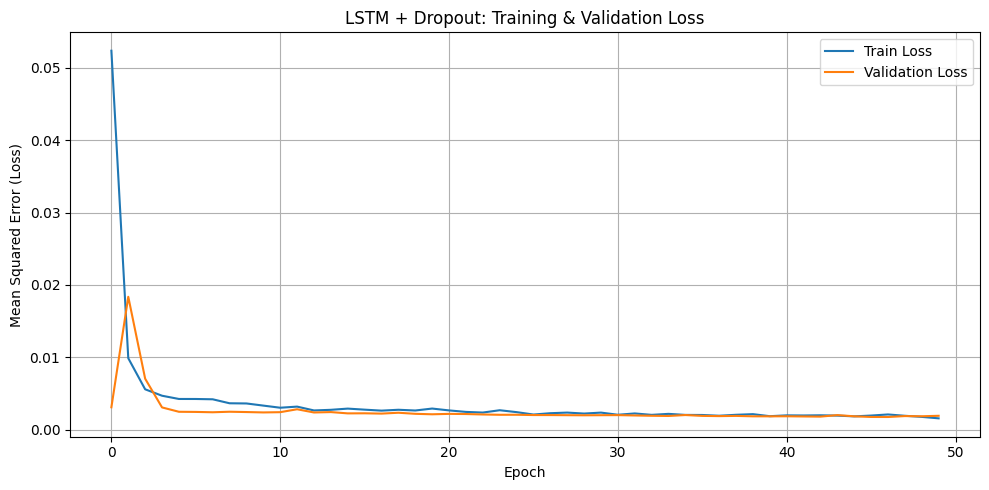

In [18]:
print("\n--- Experiment: LSTM with Dropout ---")
model_dropout_lstm = Sequential(name="Dropout_LSTM_Model")

# LSTM backbone
model_dropout_lstm.add(LSTM(32, input_shape=input_shape))
# Regularization: drop 20% of units
model_dropout_lstm.add(Dropout(0.2))
# Regression head
model_dropout_lstm.add(Dense(1))

# Compile
model_dropout_lstm.compile(optimizer="adam", loss="mean_squared_error")
model_dropout_lstm.summary()

# Train
print(f"\nTraining LSTM with Dropout for {epochs} epochs...")
history_dropout = model_dropout_lstm.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1
)

# Evaluate
mse_dropout = model_dropout_lstm.evaluate(X_test, y_test, verbose=0)
print(f"\nLSTM with Dropout – Test MSE: {mse_dropout:.6f}")

# Plot learning curves
plot_loss_curves(history_dropout, "LSTM + Dropout")

### 2e. Experiment: Different Lookback Period
Re-train the best performing model (likely LSTM or GRU) using a different `look_back` period.
Repeat the sequence creation, reshaping, and train/test split steps with `look_back = 30`. Then define, compile, train, and evaluate the chosen model architecture again.
The choice of lookback period is a hyperparameter. A shorter period (30 days) might focus more on recent trends, while a longer one (60 days) captures more historical context. This experiment helps understand how sensitive the model is to this choice.


—– Experiment: Shorter Lookback (30 days) with LSTM —–
Short Lookback Shapes:
X_train_short: (782, 30, 1)  y_train_short: (782,)
X_test_short:  (197, 30, 1)  y_test_short:  (197,)


Model: "LSTM_ShortLookback_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM with 30-day Lookback for 50 epochs...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0229 - val_loss: 0.0045
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 12/50
22/22 ━━

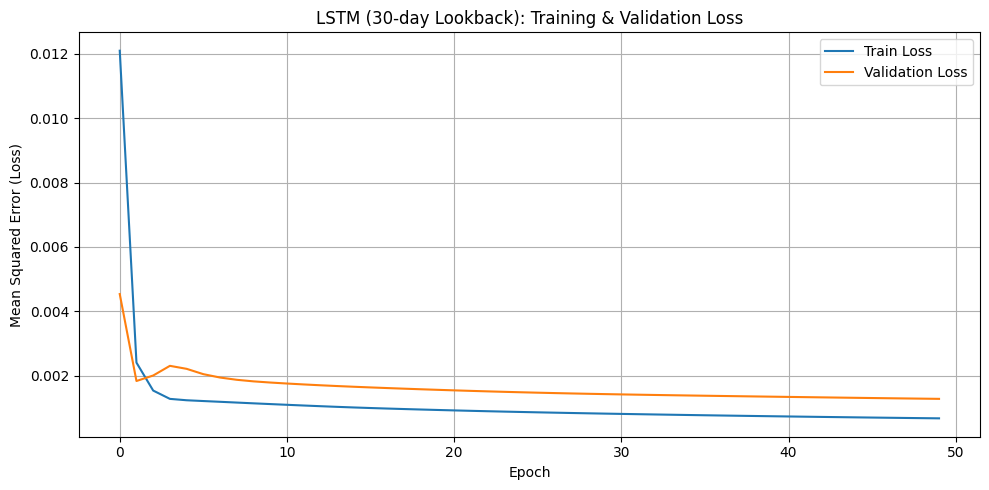

In [20]:
print("\n—– Experiment: Shorter Lookback (30 days) with LSTM —–")
look_back_short = 30

# --- Create sequences with the shorter lookback ---
X_short, y_short = create_sequences(dataset_scaled, look_back_short)

# Ensure 3D shape [samples, timesteps, features]
if X_short.ndim == 2:
    X_short = X_short.reshape((X_short.shape[0], X_short.shape[1], 1))

# --- Train/Test split (sequential, same ratio as before if available) ---
# Try to reuse previous split ratio; else default to 0.8
train_ratio = (
    (train_size / len(X)) if "train_size" in globals() and "X" in globals()
    else (train_size_percent if "train_size_percent" in globals() else 0.8)
)
train_size_short = int(len(X_short) * train_ratio)

X_train_short, y_train_short = X_short[:train_size_short], y_short[:train_size_short]
X_test_short,  y_test_short  = X_short[train_size_short:], y_short[train_size_short:]

print("Short Lookback Shapes:")
print("X_train_short:", X_train_short.shape, " y_train_short:", y_train_short.shape)
print("X_test_short: ", X_test_short.shape,  " y_test_short: ", y_test_short.shape)

# --- Build the LSTM (short lookback) ---
model_lstm_short = Sequential(name="LSTM_ShortLookback_Model")
model_lstm_short.add(LSTM(32, input_shape=(look_back_short, 1)))
model_lstm_short.add(Dense(1))

model_lstm_short.compile(optimizer="adam", loss="mean_squared_error")
model_lstm_short.summary()

# Use existing training hyperparams if present; otherwise defaults
_epochs = epochs if "epochs" in globals() else 50
_batch_size = batch_size if "batch_size" in globals() else 32

print(f"\nTraining LSTM with {look_back_short}-day Lookback for {_epochs} epochs...")
history_lstm_short = model_lstm_short.fit(
    X_train_short, y_train_short,
    epochs=_epochs,
    batch_size=_batch_size,
    validation_split=0.1,
    verbose=1
)

# --- Evaluate ---
mse_lstm_short = model_lstm_short.evaluate(X_test_short, y_test_short, verbose=0)
print(f"\nLSTM with {look_back_short}-day Lookback – Test MSE: {mse_lstm_short:.6f}")

# --- Plot learning curves ---
plot_loss_curves(history_lstm_short, f"LSTM ({look_back_short}-day Lookback)")

## Exercise 3: Analysis and Questions

**Instructions:** Answer the following questions based on the results you obtained by running the code above. Refer back to the MSE values, loss curves, and prediction plots.

**1. Initial Model Comparison (Ex 1):** 
    * Compare the **Test MSE** results from the SimpleRNN, GRU, and LSTM models (from section 1d).
    * Which model performed best (lowest Test MSE)? Which performed worst?
    * Does this outcome align with the theoretical advantages of LSTMs/GRUs (handling long-term dependencies better than SimpleRNNs)? Explain briefly.

Based on the Test MSE results from the SimpleRNN, GRU, and LSTM models from section 1d, GRU seemed to perform the best while LSTM had seemed to perform the worst. It should theoreticaly align with the theoretical advantage of LSTMs/GRU's handling long-term dependencies better than RimpleRNN's in a mixed way. LSTM is good for long-term memory and based on the results we find in section 1d, we can safely say it kind of aligns with it.

**2. Prediction Plot Analysis (Ex 2b):** 
    * Looking at the plot comparing actual vs. predicted prices on the test set, which model's predictions (dashed lines) visually seemed to follow the actual price trend most closely?
    * Does the model that *looks* best on the plot necessarily have the lowest Test MSE you recorded in Ex 1d? Discuss any similarities or differences between your visual assessment and the MSE scores.

Looking at the plot, the results seem to be mixed for RNN, GRU, and LSTM prediction. It does seem to compare with the model in example 1d and the example 1d measures best to worst based on the averages which is helpful for us to find out which is best and prevents us from visually deciding although we can to be on a safer side.

**3. Task Type & Configuration:**
    * Why did we use `mean_squared_error` as the loss function for predicting stock prices, instead of a classification loss like `categorical_crossentropy`?
    * Why does the final `Dense` layer in all models have only 1 unit and use a `linear` (default) activation function?

It is safe to use mean_squared_error for simply the fact that we're trying to predict continous values.

**4. Input Shape Explanation:** For the input shape `[samples, timesteps, features]` used in this assignment:
    * What does the `samples` dimension represent (how many sequences did we create)?
    * What does the `timesteps` dimension represent (what value did we set for `look_back` initially)?
    * What does the `features` dimension represent (how many features did we use, and what was it)?

Samples: # of training sequences (len(series) − look_back).
Timesteps: the look-back window (60 initially).
Features: # of variables per step (1, the Close price).

**5. Stacked LSTM (`return_sequences=True`) (Ex 2c):**
    * Explain *why* setting `return_sequences=True` on the *first* LSTM layer was necessary for the stacked model.
    * What is the shape of the output from an LSTM layer when `return_sequences=True` vs. `return_sequences=False` (the default)?

The first LSTM has to output the full sequence in order for the next LSTM to read it. For this reason, we set return_sequences to True in order for us to make possible.

**6. Tuning Results Analysis (Ex 2c, 2d):** 
    * Compare the **Test MSE** of the simple LSTM (Ex 1d), the Stacked LSTM (Ex 2c), and the LSTM with Dropout (Ex 2d).
    * Did stacking LSTM layers improve performance over the single LSTM layer in this case? Suggest a reason why it might have helped or hurt.
    * Did adding Dropout improve performance over the single LSTM layer? Look at the loss curves for the Dropout model and the simple LSTM - does Dropout appear to reduce overfitting (i.e., is the gap between train and validation loss smaller)? Explain.

Well, dropout does often lead to a reduction in overfitting and can even bring a little bit of a positive impact on the MSE. Stacking in general can help but at the same time it caan lead to overfitting. Based on the results, it looks somewhat helpful in doing so all of those things.

**7. Lookback Period Analysis (Ex 2e):**
    * Compare the **Test MSE** of the LSTM model with the original lookback (60 days, from Ex 1d) and the LSTM model with the shorter lookback (30 days, from Ex 2e).
    * Which lookback period resulted in better performance on the test set?
    * Why might a shorter or longer lookback period be better for predicting stock prices?

I believe that the 

## 4. Deliverables

Please submit:
1.  This completed Jupyter Notebook file (`.ipynb`) with all code cells executed and outputs (including plots and MSE values) clearly visible. **(25% penalty if submitted notebok is not executed)** 
2.  An exported HTML version or PDF version of this notebook (`File -> Download as -> HTML`). **(25% penalty if HTML or PDF is not submitted)**

Yes, I went ahead and followed the instructions about the file type to submit and to submit it with the outputs shown.